In [25]:
import sys
import json
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# geometric_features.py

In [26]:
class GeometricFeatures:
    """Extract geometric features from binary images"""

    @staticmethod
    def calculate_perimeter(image):
        """Calculate the perimeter of contours in a binary image"""
        contours, _ = cv2.findContours(
                        image,
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE
                        )
        return sum(cv2.arcLength(cnt, True) for cnt in contours)

    @staticmethod
    def compute_area(image):
        """Compute area of binary image"""
        return float(cv2.countNonZero(image))

    @staticmethod
    def compute_compactness(perimeter, area):
        """Calculate compactness = (area * 4 * pi) / (perimeter^2)"""
        if perimeter <= 0:
            return 0.0
        return (area * 4 * np.pi) / (perimeter ** 2)

    @staticmethod
    def calculate_convex_area(image):
        """Calculate area using convex hull of the largest contour"""
        contours, _ = cv2.findContours(
                        image,
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            return 0.0

        # Combine all contours points to handle multiple part drawings
        all_points = np.vstack(contours)
        hull = cv2.convexHull(all_points)
        convex_area = cv2.contourArea(hull)
        area = GeometricFeatures.compute_area(image)

        solidity = area / convex_area if convex_area > 0 else 0

        return {"convex_area": convex_area, "solidity": solidity}

# lines.py

In [27]:
class LineDetection:
    """Detect and regroup lines in images"""

    @staticmethod
    def detect_lines(image):
        """Detect lines using Hough Transform"""
        # Apply Canny edge detection
        lines = cv2.HoughLinesP(
            image,
            rho=1,
            theta=np.pi/180,
            threshold=20,      # min intersections to detect line
            minLineLength=15,  # min length of line
            maxLineGap=5       # max gap between pixels
        )

        if lines is None:
            return []

        raw_lines = [line[0] for line in lines]

        # return list of x1,y1,x2,y2
        return LineDetection.group_lines_with_limits(raw_lines)

    @staticmethod
    def classify_directions(lines):
        """Classify lines into horizontal, vertical, and diagonal"""
        results = {'horizontal': 0, 'vertical': 0, 'diag1': 0, 'diag2': 0}

        for x1, y1, x2, y2 in lines:
            label, _ = LineDetection.get_line_info(x1, y1, x2, y2)
            results[label] += 1

        return results

    @staticmethod
    def get_line_info(x1, y1, x2, y2):
        """Calculate angle and return label with color"""
        dx = x2 - x1
        dy = y2 - y1
        # Calculate angle in degrees (0-180)
        angle = np.degrees(np.arctan2(dy, dx)) % 180  # Normalize to 0-180

        if angle <= 22.5 or angle >= 157.5:
            return 'horizontal', (255, 0, 0)  # Blue
        elif 67.5 <= angle <= 112.5:
            return 'vertical', (0, 255, 0)  # Green
        elif 22.5 < angle < 67.5:
            return 'diag1', (0, 0, 255)  # Red
        else:
            return 'diag2', (0, 255, 255)  # Yellow

    @staticmethod
    def group_lines_with_limits(lines):
        """Filters lines with spatial separation and quantity limits"""
        categories = {'horizontal': [],
                      'vertical': [],
                      'diag1': [],
                      'diag2': []}

        for line in lines:
            x1, y1, x2, y2 = line
            # Calculate length for sorting
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            label, _ = LineDetection.get_line_info(x1, y1, x2, y2)

            if label in categories:
                categories[label].append((line, length))

        final_lines = []

        # Limit horizontal lines to 3
        categories['horizontal'].sort(key=lambda x: x[1], reverse=True)
        h_kept = []
        for line, _ in categories['horizontal']:
            if len(h_kept) < 3:
                mid_y = (line[1] + line[3]) / 2
                # Keep if vertical distance from others is > 10px
                if all(abs(mid_y - ((h[1] + h[3]) / 2)) > 10 for h in h_kept):
                    h_kept.append(line)

        # Limit vertical lines to 3
        categories['vertical'].sort(key=lambda x: x[1], reverse=True)
        v_kept = []
        for line, _ in categories['vertical']:
            if len(v_kept) < 3:
                mid_x = (line[0] + line[2]) / 2
                # Keep if horizontal distance from others is > 10px
                if all(abs(mid_x - ((v[0] + v[2]) / 2)) > 10 for v in v_kept):
                    v_kept.append(line)

        # Filtering diagonals too close to each other (no limits)
        for d_type in ['diag1', 'diag2']:
            categories[d_type].sort(key=lambda x: x[1], reverse=True)
            d_kept = []

            for line, _ in categories[d_type]:
                # Center point
                mid_x = (line[0] + line[2]) / 2
                mid_y = (line[1] + line[3]) / 2

                # Check distance
                is_too_close = False
                for k_line in d_kept:
                    k_mid_x = (k_line[0] + k_line[2]) / 2
                    k_mid_y = (k_line[1] + k_line[3]) / 2
                    dist = np.sqrt((mid_x - k_mid_x)**2 + (mid_y - k_mid_y)**2)

                    if dist < 5:
                        is_too_close = True
                        break

                if not is_too_close:
                    d_kept.append(line)

        final_lines.extend(h_kept)
        final_lines.extend(v_kept)
        final_lines.extend(d_kept)

        return final_lines

# diagonal.py

In [28]:
class DiagonalAnalysis:
    """Analyze diagonal properties of drawings"""

    @staticmethod
    def analyze_diagonal(image):
        """Find and measure diagonal of the drawing"""
        # Safe checking image is 1-channel (binary from process.py)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find coordinates of all non-zero (white) pixels
        coords = cv2.findNonZero(image)

        if coords is None:
            return {'length': 0, 'angle': 0}

        _, _, w, h = cv2.boundingRect(coords)  # Bounding box

        # Calculate diagonal length and angle
        diagonal_length = np.sqrt(w**2 + h**2)
        diagonal_angle = np.degrees(np.arctan2(h, w))

        return {
            'length': round(diagonal_length, 3),
            'angle': round(diagonal_angle, 3)
        }

# moments.py

In [29]:
class MomentsFeatures:
    """Extract moment-based features"""

    @staticmethod
    def get_hu_moments(image):
        """Calculate Hu moments"""
        # Calculate moments
        moments = cv2.moments(image, True)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Apply log transform to make them more manageable
        hu_moments = -np.sign(hu_moments)*np.log10(np.abs(hu_moments)+1e-10)

        return hu_moments.tolist()

    @staticmethod
    def gravity_center(image):
        """Calculate center of gravity"""
        moments = cv2.moments(image, True)

        if moments['m00'] == 0:
            return (0, 0)

        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']

        return (cx, cy)

    @staticmethod
    def average_centroidal_radius(image):
        """Calculate average centroidal radius"""
        cx, cy = MomentsFeatures.gravity_center(image)
        contours, _ = cv2.findContours(
                        image,
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE
                        )

        if not contours:
            return 0.0

        all_points = np.vstack(contours).squeeze()

        # Forcing to 2D
        if all_points.ndim == 1:  # if single point it would be 1D
            all_points = np.array([all_points])

        distances = np.sqrt(np.sum((all_points - [cx, cy])**2, axis=1))

        return float(np.mean(distances))

# poi.py

In [30]:
class POIDetection:
    """Detect points of interest, here corners only"""

    @staticmethod
    def detect_all_corners(image, epsilon_factor=0.02):
        """Detect corners with significant angle changes
            by simplifying contours into polygons
        """
        contours, _ = cv2.findContours(
                        image,
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE
                    )

        corner_count = 0
        approxs = []
        for cnt in contours:
            # Espilon : max distance from contour to approximated shape
            perimeter = cv2.arcLength(cnt, True)
            epsilon = epsilon_factor * perimeter

            # Approximate shape with a polygon
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            approxs.append(approx)

            # Number of vertices in polygon is the number of corners
            corner_count += len(approx)

        return corner_count, approxs

    @staticmethod
    def detect_sharp_corners(image,
                             max_corners=20,
                             quality_level=0.01,
                             min_distance=10):
        """Find most sharp corners using Shi-Tomasi method"""
        corners = cv2.goodFeaturesToTrack(
            image,
            maxCorners=max_corners,
            qualityLevel=quality_level,
            minDistance=min_distance
        )
        count = len(corners) if corners is not None else 0
        return count, corners

# ellipse.py

In [31]:
class EllipseDetection:
    """Detect ellipses in images"""

    @staticmethod
    def detect_ellipses(image, min_ratio=0.3, min_area=20):
        """Detect ellipses in an image"""
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        # Close small gaps in circles
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        contours, _ = cv2.findContours(image, cv2.RETR_LIST,
                                       cv2.CHAIN_APPROX_SIMPLE)

        detected_ellipses = []
        for contour in contours:
            if len(contour) < 5:
                continue
            area = cv2.contourArea(contour)
            hull_area = cv2.contourArea(cv2.convexHull(contour))
            solidity = area / hull_area if hull_area > 0 else 0
            if solidity > 0.92 and area >= min_area:

                ellipse = cv2.fitEllipse(contour)
                # Aspect ratio
                w, h = ellipse[1]
                ratio = min(w, h) / max(w, h) if max(w, h) > 0 else 0

                # Circularity (making sure it's not a random pt scatter)
                perimeter = cv2.arcLength(contour, True)
                circularity = 0
                if perimeter > 0:
                    circularity = (4*np.pi*area)/(perimeter**2)

                if ratio > min_ratio and circularity > 0.75:  # Thresholds
                    detected_ellipses.append(ellipse)

        # Sort (descending) by area
        detected_ellipses.sort(key=lambda e: e[1][0] * e[1][1], reverse=True)
        # Filter overlapping ellipses and select top 2
        # (we don't expect more than 2 ellipses in icons)
        top_ellipses = EllipseDetection.filter_overlapping_ellipses(
            detected_ellipses, max_out=2)

        if len(top_ellipses) == 2:
            area1 = top_ellipses[0][1][0] * top_ellipses[0][1][1]
            area2 = top_ellipses[1][1][0] * top_ellipses[1][1][1]

            # If biggest ellipse is way larger than the second,
            # it's not wheels which is the only pair of circle acceptable
            # So we keep only the main one.
            if area1 > area2 * 3:
                return [top_ellipses[0]]

        return top_ellipses

    @staticmethod
    def filter_overlapping_ellipses(ellipses, overlap_threshold=0.6,
                                    max_out=2):
        """Filter overlapping ellipses, returning maximum 'max_out' results"""
        if not ellipses:
            return []

        filtered = []
        for candidate in ellipses:
            if len(filtered) >= max_out:
                break

            is_overlap = False
            c1 = candidate[0]
            # Radius based filtering
            r1 = max(candidate[1]) / 2

            for fixed in filtered:
                c2 = fixed[0]
                r2 = max(fixed[1]) / 2

                # distance between centers
                dist = np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)

                # if centers are closer than a % of the largest radius
                if dist < max(r1, r2) * overlap_threshold:
                    is_overlap = True
                    break

            if not is_overlap:
                filtered.append(candidate)

        return filtered

# subdivider.py

In [32]:
class ImageSubdivision:
    """Subdivide images into grid cells"""

    @staticmethod
    def subdivide(image, rows, cols):
        """Divide image into rows x cols sub images"""
        sub_image_height = image.shape[0] // rows
        sub_image_width = image.shape[1] // cols

        sub_images = []

        for i in range(rows):
            for j in range(cols):
                x = j * sub_image_width
                y = i * sub_image_height
                sub_image = image[y:y + sub_image_height,
                                  x:x + sub_image_width].copy()
                sub_images.append(sub_image)

        return sub_images

# main.py

In [33]:
class IconFeatureExtractor:
    """Consolidated feature extraction pipeline with optimized logic"""

    def __init__(self, rows=2, cols=3):
        self.rows = rows
        self.cols = cols

    def extract_core_features(self, binary):
        """Helper to extract shared features for both global and sub-zones"""
        # Lines
        filtered_lines = LineDetection.detect_lines(binary)
        line_directions = LineDetection.classify_directions(filtered_lines)

        # POI
        total_corners, _ = POIDetection.detect_all_corners(binary)
        sharp_corners, _ = POIDetection.detect_sharp_corners(binary)

        # Geometry & Moments
        perimeter = GeometricFeatures.calculate_perimeter(binary)
        area = GeometricFeatures.compute_area(binary)
        compactness = GeometricFeatures.compute_compactness(perimeter, area)
        hu_moments = MomentsFeatures.get_hu_moments(binary)

        return {
            'perimeter': perimeter,
            'area': int(area),
            'compactness': compactness,
            'hu_moments': hu_moments,
            'corners_count': total_corners,
            'sharp_corners_count': sharp_corners,
            'line_directions': line_directions
        }

    def extract_features_from_image(self, image_path):
        """Extract features from a single image using consolidated logic"""
        image = cv2.imread(str(image_path))
        if image is None:
            return None

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

        # Subdivision features extraction
        sub_zones = ImageSubdivision.subdivide(binary, self.rows, self.cols)
        subdivision_features = []
        for zone in sub_zones:
            subdivision_features.append(self.extract_core_features(zone))

        # Global features extraction
        features = {'subdivisions': subdivision_features}
        global_f = self.extract_core_features(binary)

        # Adding global features
        ellipses = EllipseDetection.detect_ellipses(binary)
        diag = DiagonalAnalysis.analyze_diagonal(binary)
        convex_area = GeometricFeatures.calculate_convex_area(binary)
        avg_centr_radius = MomentsFeatures.average_centroidal_radius(binary)

        global_f.update({
            'ellipse_count': len(ellipses),
            'diagonal_length': diag['length'],
            'diagonal_angle': diag['angle'],
            'convex_area': convex_area,
            'avg_centroidal_radius': avg_centr_radius
        })

        features['global'] = global_f
        return features

    def process_dataset(self, data_dir, output_json='features_dataset.json'):
        """Walks through folders, extracts features, and save to JSON"""
        data_dir = Path(data_dir)
        dataset = []

        if not data_dir.exists():
            print(f"Error: Directory {data_dir} does not exist.")
            return

        print(f"Scanning directory: {data_dir}")

        for label_folder in filter(Path.is_dir, data_dir.iterdir()):
            label = label_folder.name
            if label in ["duplicates", "detection"]:
                continue
            print(f"Processing class: {label}")
            
            for img_file in label_folder.glob('*.png'):
                feat = self.extract_features_from_image(img_file)
                if feat:
                    feat.update({'label': label, 'filename': img_file.name})
                    dataset.append(feat)

        # Output JSON to the Root directory (parent of notebooks)
        # assuming the notebook is running inside /notebooks
        output_path = Path("..") / output_json
        
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(dataset, f, indent=2)
        
        print(f"\nSuccessfully processed {len(dataset)} images.")
        print(f"Features saved to: {output_path.resolve()}")
        return 0

1. Geometric Stats -> Area: 1693.0, Perimeter: 585.23
2. Lines Detected: 9


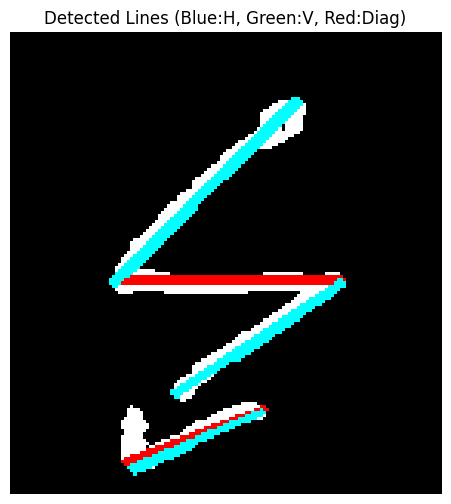

3. Sharp Corners Detected: 20


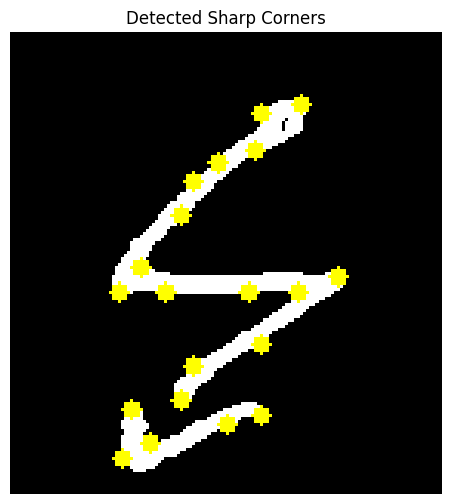

4. Ellipses Detected: 0
5. Hu Moments (Log Transformed):
[ 0.06230095  0.56242543  2.55535959  2.42594172  5.06316553  2.72605749
 -5.07111183]


In [34]:
def plot_features(image, lines=None, corners=None, ellipses=None, title="Features"):
    debug_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Draw Lines
    if lines:
        for line in lines:
            x1, y1, x2, y2 = line
            _, color = LineDetection.get_line_info(x1, y1, x2, y2)
            cv2.line(debug_img, (x1, y1), (x2, y2), color, 2)
            
    # Draw Corners
    if corners is not None:
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(debug_img, (int(x), int(y)), 3, (255, 255, 0), -1)

    # Draw Ellipses
    if ellipses:
        for el in ellipses:
            cv2.ellipse(debug_img, el, (255, 0, 255), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(debug_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

demo_icon_path = "../data/extracted/Electricity/Electricity_00000_1_0.png" 

demo_img = cv2.imread(demo_icon_path, 0)
if demo_img is not None:
    # Ensure binary
    _, binary_demo = cv2.threshold(demo_img, 127, 255, cv2.THRESH_BINARY)
    
    # Geometric Features
    area = GeometricFeatures.compute_area(binary_demo)
    perimeter = GeometricFeatures.calculate_perimeter(binary_demo)
    print(f"1. Geometric Stats -> Area: {area}, Perimeter: {perimeter:.2f}")

    # Line Detection
    detected_lines = LineDetection.detect_lines(binary_demo)
    print(f"2. Lines Detected: {len(detected_lines)}")
    plot_features(binary_demo, lines=detected_lines, title="Detected Lines (Blue:H, Green:V, Red:Diag)")
    
    # Corner Detection
    _, detected_corners = POIDetection.detect_sharp_corners(binary_demo)
    print(f"3. Sharp Corners Detected: {len(detected_corners) if detected_corners is not None else 0}")
    plot_features(binary_demo, corners=detected_corners, title="Detected Sharp Corners")
    
    # Ellipse Detection
    detected_ellipses = EllipseDetection.detect_ellipses(binary_demo)
    print(f"4. Ellipses Detected: {len(detected_ellipses)}")
    if detected_ellipses:
         plot_features(binary_demo, ellipses=detected_ellipses, title="Detected Ellipses")
         
    # Hu Moments
    hu = MomentsFeatures.get_hu_moments(binary_demo)
    print("5. Hu Moments (Log Transformed):")
    print(np.array(hu))

# Execution

In [35]:
# Path to the extracted images
EXTRACTED_DATA_PATH = "../data/extracted"
OUTPUT_FILENAME = "features_dataset.json"

# Run the pipeline
extractor = IconFeatureExtractor()
extractor.process_dataset(EXTRACTED_DATA_PATH, OUTPUT_FILENAME)

Scanning directory: ..\data\extracted
Processing class: Bomb
Processing class: Car
Processing class: Casualty
Processing class: Electricity
Processing class: Fire
Processing class: Fire_brigade
Processing class: Flood
Processing class: Gas
Processing class: Injury
Processing class: Paramedics
Processing class: Person
Processing class: Police
Processing class: Road_block
Processing class: Warning

Successfully processed 2095 images.
Features saved to: C:\Users\PC1\OneDrive\Desktop\ders\deeplearning\project\code\Emergency-Icon-Classification-using-Deep-Learning\features_dataset.json


0